In [ ]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 799.8 kB/s eta 0:00:00


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import time
# import utils.utils as utils
# Defining the global variables.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8
# Training for single epoch for time constraint.
# Please use atleast 30 epochs to see good results.
EPOCHS = 1
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# gpus = tf.config.experimental.list_physical_devices('CPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
#   except RuntimeError as e:
#     print(e)
# tf.config.experimental.set_visible_devices([], 'GPU')
# print()

In [ ]:
def decode_and_resize(image_path):
    """Decodes and resizes an image from the image file path.

    Args:
        image_path: The image file path.

    Returns:
        A resized image.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


def extract_image_from_voc(element):
    """Extracts image from the PascalVOC dataset.

    Args:
        element: A dictionary of data.

    Returns:
        A resized image.
    """
    image = element["image"]
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image




In [ ]:
# Get the image file paths for the style images.
style_path = "/content/data/style"
style_images = os.listdir(style_path)
style_images = [os.path.join(style_path, path) for path in style_images]

# split the style images in train, val and test
total_style_images = len(style_images)
train_style = style_images[: int(0.8 * total_style_images)]
val_style = style_images[int(0.8 * total_style_images) : int(0.9 * total_style_images)]
test_style = style_images[int(0.9 * total_style_images) :]

# Get the image file paths for the style images.
content_path = "/content/data/content"
content_images = os.listdir(content_path)
content_images = [os.path.join(content_path, path) for path in content_images]

# split the style images in train, val and test
total_content_images = len(content_images)
train_content = content_images[: int(0.8 * total_content_images)]
val_content = content_images[int(0.8 * total_content_images) : int(0.9 * total_content_images)]
test_content = content_images[int(0.9 * total_content_images) :]

# Build the style and content tf.data datasets.
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
train_content_ds = (
    tf.data.Dataset.from_tensor_slices(train_content)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
# train_content_ds = tfds.load("voc", split="validation").map(extract_image_from_voc).repeat()

val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
val_content_ds = (
    tfds.load("voc", split="validation").map(extract_image_from_voc).repeat()
)

test_style_ds = (
    tf.data.Dataset.from_tensor_slices(test_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
test_content_ds = (
    tfds.load("voc", split="test")
    .map(extract_image_from_voc, num_parallel_calls=AUTOTUNE)
    .repeat()
)

# Zipping the style and content datasets.
train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.zip((test_style_ds, test_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteU7W6XO/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteU7W6XO/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteU7W6XO/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


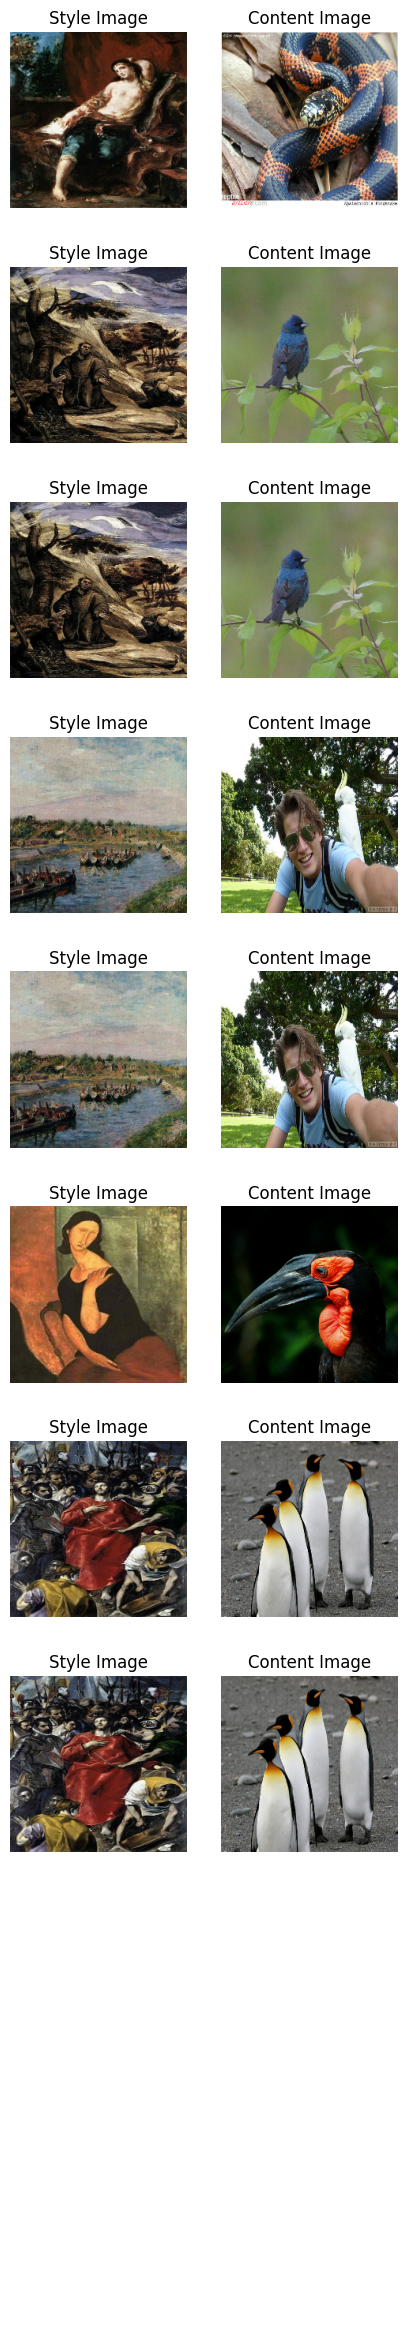

In [ ]:
style, content = next(iter(train_ds))
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(5, 30))
[ax.axis("off") for ax in np.ravel(axes)]

for (axis, style_image, content_image) in zip(axes, style[0:10], content[0:10]):
    (ax_style, ax_content) = axis
    ax_style.imshow(style_image)
    ax_style.set_title("Style Image")

    ax_content.imshow(content_image)
    ax_content.set_title("Content Image")

In [ ]:
def get_encoder():
    vgg19 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(*IMAGE_SIZE, 3),
    )
    vgg19.trainable = False
    mini_vgg19 = keras.Model(vgg19.input, vgg19.get_layer("block4_conv1").output)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="mini_vgg19")

In [ ]:
def get_mean_std(x, epsilon=1e-5):
    axes = [1, 2]

    # Compute the mean and standard deviation of a tensor.
    mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
    standard_deviation = tf.sqrt(variance + epsilon)
    return mean, standard_deviation


def ada_in(style, content):
    """Computes the AdaIn feature map.

    Args:
        style: The style feature map.
        content: The content feature map.

    Returns:
        The AdaIN feature map.
    """
    content_mean, content_std = get_mean_std(content)
    style_mean, style_std = get_mean_std(style)
    t = style_std * (content - content_mean) / content_std + style_mean
    return t

In [ ]:
def get_decoder():
    config = {"kernel_size": 3, "strides": 1, "padding": "same", "activation": "relu"}
    decoder = keras.Sequential(
        [
            layers.InputLayer((None, None, 512)),
            layers.Conv2D(filters=512, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=128, **config),
            layers.Conv2D(filters=128, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=64, **config),
            layers.Conv2D(
                filters=3,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="sigmoid",
            ),
        ]
    )
    return decoder

In [ ]:
def get_loss_net():
    vgg19 = keras.applications.VGG19(
        include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3)
    )
    vgg19.trainable = False
    layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    outputs = [vgg19.get_layer(name).output for name in layer_names]
    mini_vgg19 = keras.Model(vgg19.input, outputs)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="loss_net")

In [ ]:
class NeuralStyleTransfer(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_net, style_weight, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_net = loss_net
        self.style_weight = style_weight

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.style_loss_tracker = keras.metrics.Mean(name="style_loss")
        self.content_loss_tracker = keras.metrics.Mean(name="content_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        with tf.GradientTape() as tape:
            # Encode the style and content image.
            style_encoded = self.encoder(style)
            content_encoded = self.encoder(content)

            # Compute the AdaIN target feature maps.
            t = ada_in(style=style_encoded, content=content_encoded)

            # Generate the neural style transferred image.
            reconstructed_image = self.decoder(t)

            # Compute the losses.
            reconstructed_vgg_features = self.loss_net(reconstructed_image)
            style_vgg_features = self.loss_net(style)
            loss_content = self.loss_fn(t, reconstructed_vgg_features[-1])
            for inp, out in zip(style_vgg_features, reconstructed_vgg_features):
                mean_inp, std_inp = get_mean_std(inp)
                mean_out, std_out = get_mean_std(out)
                loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                    std_inp, std_out
                )
            loss_style = self.style_weight * loss_style
            total_loss = loss_content + loss_style

        # Compute gradients and optimize the decoder.
        trainable_vars = self.decoder.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        # Encode the style and content image.
        style_encoded = self.encoder(style)
        content_encoded = self.encoder(content)

        # Compute the AdaIN target feature maps.
        t = ada_in(style=style_encoded, content=content_encoded)

        # Generate the neural style transferred image.
        reconstructed_image = self.decoder(t)

        # Compute the losses.
        recons_vgg_features = self.loss_net(reconstructed_image)
        style_vgg_features = self.loss_net(style)
        loss_content = self.loss_fn(t, recons_vgg_features[-1])
        for inp, out in zip(style_vgg_features, recons_vgg_features):
            mean_inp, std_inp = get_mean_std(inp)
            mean_out, std_out = get_mean_std(out)
            loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                std_inp, std_out
            )
        loss_style = self.style_weight * loss_style
        total_loss = loss_content + loss_style

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [
            self.style_loss_tracker,
            self.content_loss_tracker,
            self.total_loss_tracker,
        ]

In [ ]:
test_style, test_content = next(iter(test_ds))


class TrainMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Encode the style and content image.
        test_style_encoded = self.model.encoder(test_style)
        test_content_encoded = self.model.encoder(test_content)

        # Compute the AdaIN features.
        test_t = ada_in(style=test_style_encoded, content=test_content_encoded)
        test_reconstructed_image = self.model.decoder(test_t)

        # Plot the Style, Content and the NST image.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(tf.keras.utils.array_to_img(test_style[0]))
        ax[0].set_title(f"Style: {epoch:03d}")

        ax[1].imshow(tf.keras.utils.array_to_img(test_content[0]))
        ax[1].set_title(f"Content: {epoch:03d}")

        ax[2].imshow(
            tf.keras.utils.array_to_img(test_reconstructed_image[0])
        )
        ax[2].set_title(f"NST: {epoch:03d}")

        plt.show()
        plt.close()

1/1 [==============================] - ETA: 0s - style_loss: 333.5360 - content_loss: 192.1906 - total_loss: 525.7266

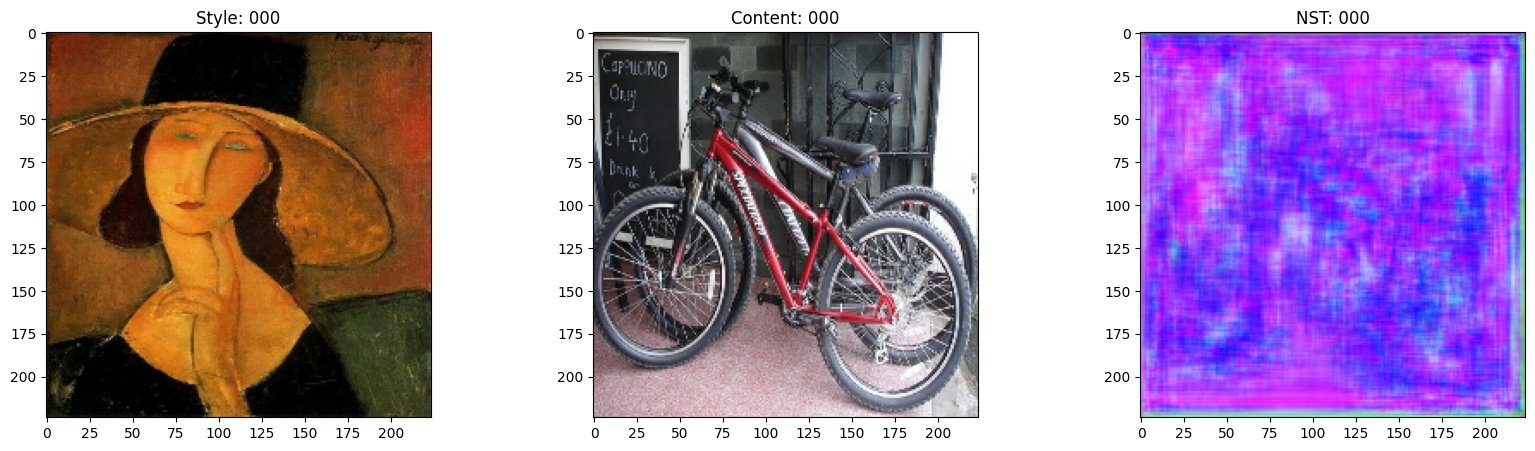

1/1 [==============================] - 96s 96s/step - style_loss: 333.5360 - content_loss: 192.1906 - total_loss: 525.7266 - val_style_loss: 236.4294 - val_content_loss: 163.8775 - val_total_loss: 400.3069


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = keras.losses.MeanSquaredError()

encoder = get_encoder()
loss_net = get_loss_net()
decoder = get_decoder()

model = NeuralStyleTransfer(
    encoder=encoder, decoder=decoder, loss_net=loss_net, style_weight=4.0
)

model.compile(optimizer=optimizer, loss_fn=loss_fn)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=1,
    validation_data=val_ds,
    validation_steps=1,
    callbacks=[TrainMonitor()],
)

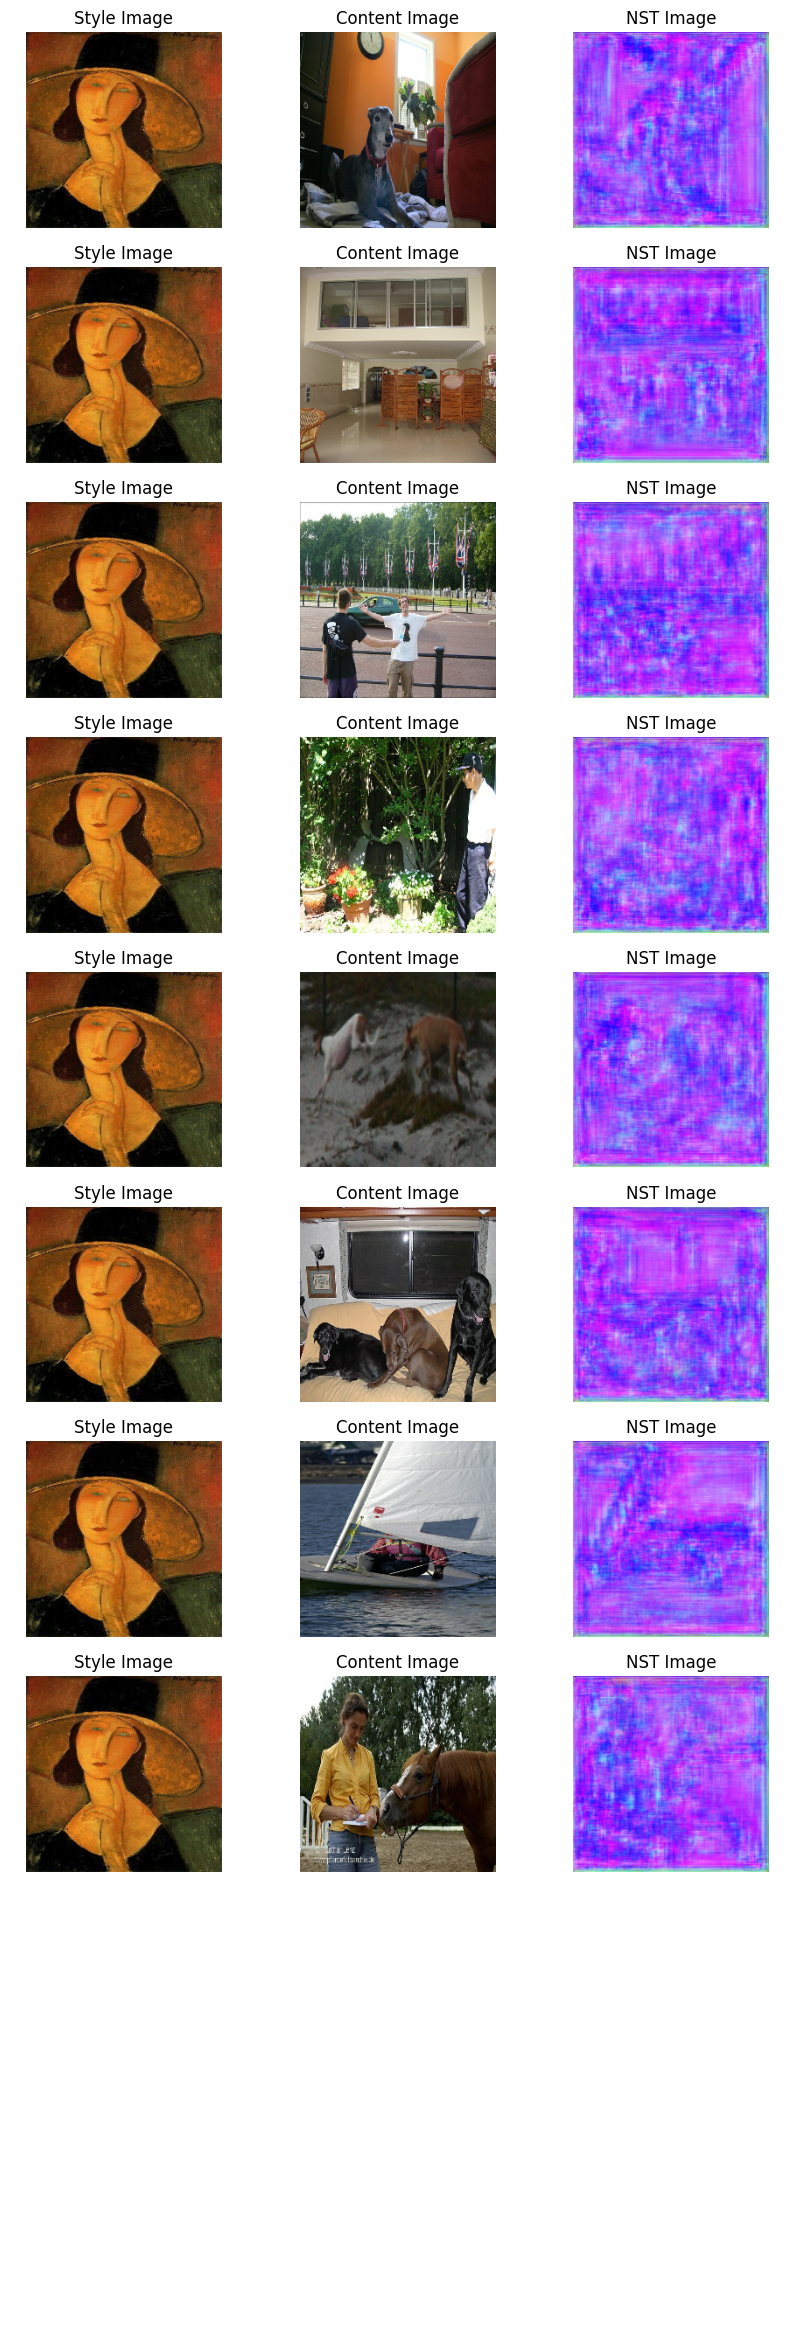

In [ ]:
for style, content in test_ds.take(1):
    style_encoded = model.encoder(style)
    content_encoded = model.encoder(content)
    t = ada_in(style=style_encoded, content=content_encoded)
    reconstructed_image = model.decoder(t)
    fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 30))
    [ax.axis("off") for ax in np.ravel(axes)]

    for axis, style_image, content_image, reconstructed_image in zip(
        axes, style[0:10], content[0:10], reconstructed_image[0:10]
    ):
        (ax_style, ax_content, ax_reconstructed) = axis
        ax_style.imshow(style_image)
        ax_style.set_title("Style Image")
        ax_content.imshow(content_image)
        ax_content.set_title("Content Image")
        ax_reconstructed.imshow(reconstructed_image)
        ax_reconstructed.set_title("NST Image")

# Implementation for Masked Video Style Transfer Network begins here

In [51]:
def get_mean_std(x, epsilon=1e-5):
    axes = [1, 2]

    # Compute the mean and standard deviation of a tensor.
    mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
    standard_deviation = tf.sqrt(variance + epsilon)
    return mean, standard_deviation

def st_ada_in(style_features, content_cur_masked_features, content_prev_masked_features, alpha = 0.1):
    print('#', style_features.shape, content_cur_masked_features.shape, content_prev_masked_features.shape)

    x_cur_mean, x_cur_std = get_mean_std(content_cur_masked_features)
    x_prev_mean, x_prev_std = get_mean_std(content_prev_masked_features)

    # print('#', type(alpha), type(x_cur_mean), type(x_prev_mean))
    combined_mean = (1-alpha) * x_cur_mean + alpha * x_prev_mean
    combined_std = (1-alpha) * x_cur_std + alpha * x_prev_std

    style_mean, style_std = get_mean_std(style_features)

    result = style_std * (content_cur_masked_features - combined_mean) / combined_std + style_mean
    print('#', x_cur_mean.shape, result.shape)
    return result

def get_VGG_feature_extractor():
    vgg_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    vgg_fixed = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_fixed.trainable = False
    outputs = [vgg_fixed.get_layer(name).output for name in vgg_layer_names]
    return tf.keras.Model(inputs=vgg_fixed.input, outputs=outputs)


class SpatioTemporalTransferModel(tf.keras.Model):
    #generates bilateral grids for each class
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # self.vgg_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]

        # self.vgg_fixed = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        # self.vgg_fixed.trainable = False
        self.vgg_feature_extractor = get_VGG_feature_extractor()

        #define splatting blocks' layers
        self.sb_11 = layers.Conv2D(
                filters=8,
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )
        self.sb_12 = layers.Conv2D(
                filters=8,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )
        self.sb_13 = layers.Conv2D(
                filters=8,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )
        self.sb_1_short = layers.Conv2D(
                filters=8,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )

        self.sb_21 = layers.Conv2D(
                filters=16,
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )
        self.sb_22 = layers.Conv2D(
                filters=16,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )
        self.sb_23 = layers.Conv2D(
                filters=16,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )
        self.sb_2_short = layers.Conv2D(
                filters=16,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )

        self.sb_31 = layers.Conv2D(
                filters=32,
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )
        self.sb_32 = layers.Conv2D(
                filters=32,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )
        self.sb_33 = layers.Conv2D(
                filters=32,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )
        self.sb_3_short = layers.Conv2D(
                filters=32,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )

        self.l_1 = layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )

        self.l_2 = layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )

        self.gp_1 = layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )

        self.gp_2 = layers.Conv2D(
                filters=96,
                kernel_size=1,
                strides=1,
                padding="same",
                activation="relu",
            ) #TODO : activation none?

    def forward(self, style, content, mask, content_prev_encoded, temp_content_prev_1, temp_content_prev_2, temp_content_prev_3, mask_prev):
        # Encode the style and content image.

        style_encoded = self.vgg_feature_extractor.predict(style)

        content_encoded = self.vgg_feature_extractor.predict(content * mask)

        # for c in content_encoded:
        #     print(c.shape)
            # print(c)
            # break

        # Compute the AdaIN target feature maps.
        st_ada_in_outputs = []
        # skip block1_conv1
        skipCount = 1
        count = 0

        # print('!!!!!!', len(style_encoded), len(content_encoded), len(content_prev_encoded))

        for encoded_features in zip(style_encoded, content_encoded, content_prev_encoded):
            # print('! ', count)
            if count < skipCount:
                count += 1
                continue
            # TODO : manage prev features and consider mask shape
            st_ada_in_output = st_ada_in(encoded_features[0], encoded_features[1], encoded_features[2], alpha = 0.1)
            st_ada_in_outputs.append(st_ada_in_output)

        temp_content = self.sb_11(content_encoded[0]) #input is c_in
        temp_style = self.sb_11(style_encoded[0]) #input is s_in
        #TODO corresponding prev variables and mask
        temp_content_stylized = st_ada_in(temp_style, temp_content, temp_content_prev_1, alpha = 0.1)
        temp_content_prev_1 = tf.Variable(temp_content)
        temp_content_stylized = temp_content_stylized + self.sb_1_short(st_ada_in_outputs[0])
        temp_content_stylized = self.sb_12(temp_content_stylized)
        temp_content_stylized = self.sb_13(temp_content_stylized) #c_out
        print('here', temp_style.shape)
        temp_style = self.sb_13(temp_style) #s_out

        temp_content = self.sb_21(temp_content_stylized) #input is c_in
        temp_style = self.sb_21(temp_style) #input is s_in
        #TODO corresponding prev variables and mask
        temp_content_stylized = st_ada_in(temp_style, temp_content, temp_content_prev_2, alpha = 0.1)
        temp_content_prev_2 = tf.Variable(temp_content)
        temp_content_stylized = temp_content_stylized + self.sb_2_short(st_ada_in_outputs[1])
        temp_content_stylized = self.sb_22(temp_content_stylized)
        temp_content_stylized = self.sb_23(temp_content_stylized) #c_out
        temp_style = self.sb_23(temp_style) #s_out

        temp_content = self.sb_31(temp_content_stylized) #input is c_in
        temp_style = self.sb_31(temp_style) #input is s_in
        #TODO corresponding prev variables and mask
        temp_content_stylized = st_ada_in(temp_style, temp_content, temp_content_prev_3, alpha = 0.1)
        temp_content_prev_3 = tf.Variable(temp_content)
        temp_content_stylized = temp_content_stylized + self.sb_3_short(st_ada_in_outputs[2])
        temp_content_stylized = self.sb_32(temp_content_stylized)
        temp_content_stylized = self.sb_33(temp_content_stylized) #c_out
        temp_style = self.sb_33(temp_style) #s_out

        temp_content_stylized = self.l_1(temp_content_stylized)
        temp_content_stylized = self.l_2(temp_content_stylized) #stylized_features

        #grid prediction
        bilateral_grid = self.gp_1(temp_content_stylized)
        bilateral_grid = self.gp_2(bilateral_grid)

        content_prev_encoded = content_encoded.copy()

        return bilateral_grid, content_prev_encoded, temp_content_prev_1, temp_content_prev_2, temp_content_prev_3

class SoftGridMask(tf.keras.Model):
    def __init__(self):
        pass

    def create_soft_grid_mask(self, z, M_px, w, h, W, H, D):
        #TODO check reduce_sum against algo
        M_grid = np.zeros((W, H, D))
        z_D = tf.math.floor((z * M_px) * D)
        s_w, s_h = w//W, h//H

        for x in range(W):
            for y in range(H):
                patch = z_D[x * s_w : (x + 1) * s_w, y*s_h:(y+1)*s_h]
                M_grid[x,y,:] = tf.math.reduce_sum(tf.where(patch > 0, patch, tf.zeros_like(patch)))
                for d in range(D):
                    if d in patch.numpy():
                        M_grid[x,y,d] = tf.math.reduce_sum(tf.where(patch == d, patch, tf.zeros_like(patch)))
        M_grid = M_grid / (s_w * s_h)
        return M_grid

    def forward(self, inputs):
        #TODO : use create mask function
        pass

class GridBlender(tf.keras.Model):
    def __init__(self):
        pass

    def forward(self, inputs):
        #TODO : use grid blending function
        pass

class GuideNN(tf.keras.Model):
    def __init__(self, params=None):
        super(GuideNN, self).__init__()
        self.params = params
        self.conv1 = layers.Conv2D(
                filters=16,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="relu",
            )
        self.conv2 = layers.Conv2D(
                filters=1,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="sigmoid",
            )

    def call(self, x):
        return self.conv2(self.conv1(x))


class Slice(tf.keras.Model):
    def __init__(self):
        super(Slice, self).__init__()

    def call(self, bilateral_grid, guidemap):
        N, _, H, W = guidemap.shape
        hg, wg = tf.meshgrid([tf.range(0, H), tf.range(0, W)]) # [0,511] HxW
        hg = tf.cast(hg, tf.float32) / (H-1) * 2 - 1 # norm to [-1,1] NxHxWx1
        wg = tf.cast(wg, tf.float32) / (W-1) * 2 - 1 # norm to [-1,1] NxHxWx1
        guidemap = tf.transpose(guidemap, perm=[0, 2, 3, 1])
        guidemap_guide = tf.concat([wg, hg, guidemap], axis=3) # NxHxWx3
        guidemap_guide = tf.expand_dims(guidemap_guide, axis=1) # Nx1xHxWx3
        coeff = tf.raw_ops.GridSample(bilateral_grid, guidemap_guide) # Assuming 'bilateral_grid' is a tensor
        return tf.squeeze(coeff, axis=2)


# class ConvBlock(tf.keras.layers.Layer):
#     def __init__(self, inc, outc, kernel_size=3, padding=1, stride=1, use_bias=True, activation=tf.keras.activations.relu,
#                  batch_norm=False):
#         super(ConvBlock, self).__init__()
#         self.conv = tf.keras.layers.Conv2D(outc, kernel_size, padding=padding, strides=stride, use_bias=use_bias)
#         self.activation = activation if activation else None
#         self.bn = tf.keras.layers.BatchNormalization() if batch_norm else None

#     def call(self, x):
#         x = self.conv(x)
#         if self.bn:
#             x = self.bn(x)
#         if self.activation:
#             x = self.activation(x)
#         return x


class ApplyCoeffs(tf.keras.layers.Layer):
    def __init__(self):
        super(ApplyCoeffs, self).__init__()
        self.degree = 3

    def call(self, coeff, full_res_input):

        '''
            Affine:
            r = a11*r + a12*g + a13*b + a14
            g = a21*r + a22*g + a23*b + a24
            ...
        '''

        R = tf.reduce_sum(full_res_input * coeff[:, 0:3, :, :], axis=1, keepdims=True) + coeff[:, 3:4, :, :]
        G = tf.reduce_sum(full_res_input * coeff[:, 4:7, :, :], axis=1, keepdims=True) + coeff[:, 7:8, :, :]
        B = tf.reduce_sum(full_res_input * coeff[:, 8:11, :, :], axis=1, keepdims=True) + coeff[:, 11:12, :, :]

        return tf.concat([R, G, B], axis=1)

class MaskedVideoStyleTransfer(tf.keras.Model):
    def __init__(self, spatio_temporal_model, grid_blender, guide, slice, apply_coeffs):
        self.spatio_temporal_model = spatio_temporal_model
        self.grid_blender = grid_blender
        self.guide = guide
        self.slice = slice
        self.apply_coeffs = apply_coeffs


    def forward(self, inputs):
        content, mask_cur_list, style_list, content_prev, mask_prev_list = inputs

        #prev values
        content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list = None, None, None, None

        bilateral_grid_list = []
        for classId in len(mask_cur_list):
            bilateral_grid, content_prev_encoded, temp_content_prev_1, temp_content_prev_2, temp_content_prev_3 = self.spatio_temporal_model(style_list[classId], content, mask_cur_list[classId], content_prev_encoded_list[classId], temp_content_prev_1_list[classId], temp_content_prev_2_list[classId], temp_content_prev_3_list[classId])

            content_prev_encoded_list[classId], temp_content_prev_1_list[classId], temp_content_prev_2_list[classId], temp_content_prev_3_list[classId] = content_prev_encoded, temp_content_prev_1, temp_content_prev_2, temp_content_prev_3

            bilateral_grid_list.append(bilateral_grid)

        blended_grid = self.grid_blender(bilateral_grid_list)
        guide = self.guide(content)
        slice_coeffs = self.slice(blended_grid, guide)
        output = self.apply_coeffs(slice_coeffs, content)

        #TODO : loss calculation, gradient calculation, backpropagation
        return output



In [52]:
stm = SpatioTemporalTransferModel()

In [53]:
V = 256
D = 224
temp = np.ones((1,V,V,3))
# print(temp.shape)
a,b,c,d,e = stm.forward(temp, temp,
            tf.convert_to_tensor(np.ones((1,V,V,1)), dtype=tf.float32), [tf.convert_to_tensor(np.zeros((1, 224, 224, 64)), dtype=tf.float32), tf.convert_to_tensor(np.zeros((1, 112, 112, 128)), dtype=tf.float32), tf.convert_to_tensor(np.zeros((1, 56, 56, 256)), dtype=tf.float32), tf.convert_to_tensor(np.zeros((1, 28, 28, 512)), dtype=tf.float32)],
            tf.convert_to_tensor(np.zeros((1, 112, 112, 8)), dtype=tf.float32), tf.convert_to_tensor(np.zeros((1, 56, 56, 16)), dtype=tf.float32),
            tf.convert_to_tensor(np.zeros((1, 28, 28, 32)), dtype=tf.float32), tf.convert_to_tensor(np.ones((1,V,V,1)), dtype=tf.float32))

1/1 [==============================] - 1s 752ms/step
# (1, 128, 128, 128) (1, 128, 128, 128) (1, 112, 112, 128)
# (1, 1, 1, 128) (1, 128, 128, 128)
# (1, 64, 64, 256) (1, 64, 64, 256) (1, 56, 56, 256)
# (1, 1, 1, 256) (1, 64, 64, 256)
# (1, 32, 32, 512) (1, 32, 32, 512) (1, 28, 28, 512)
# (1, 1, 1, 512) (1, 32, 32, 512)
# (1, 128, 128, 8) (1, 128, 128, 8) (1, 112, 112, 8)
# (1, 1, 1, 8) (1, 128, 128, 8)
here (1, 128, 128, 8)
# (1, 64, 64, 16) (1, 64, 64, 16) (1, 56, 56, 16)
# (1, 1, 1, 16) (1, 64, 64, 16)
# (1, 32, 32, 32) (1, 32, 32, 32) (1, 28, 28, 32)
# (1, 1, 1, 32) (1, 32, 32, 32)


In [54]:
g = GuideNN()
z = g(tf.convert_to_tensor(np.ones((1,256,256,3)), dtype=tf.float32))

In [55]:

# # training steps :
# content_prev = None
# style_list = [] #set style for each class
# content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list = None, None, None, None
# for content in video_frames:
#     mask_list = get_masks_for_frame(content)
#     improved_mask_list = improve_masks(mask_list, content)
#     train_step(content, improved_mask_list, content_prev, mask_prev_list, style_list, content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list)
#     content_prev = content.copy()
#     mask_prev_list = improved_mask_list.copy()




In [56]:
print(a.shape)

(1, 32, 32, 96)


In [58]:
sgm = SoftGridMask()
sm = sgm.create_soft_grid_mask(z, tf.convert_to_tensor(np.ones((1, 256, 256, 1)), dtype=tf.float32), 256, 256, 32, 32, 96)
print(sm.shape)

(32, 32, 96)
